In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
from torch.nn.functional import softmax, relu
from torch_geometric.nn import dense_diff_pool
from torch_geometric.transforms import BaseTransform
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [88]:
gnn.config.set_gpu(True)

In [177]:
import utils.torchUtils as gnn 
template = gnn.Dataset('../data/template',make_template=True, transform=gnn.min_edge_neighbor(n_neighbor=3))

def load_dataset(fn='../data/MX_1200_MY_500-training', template=None, shuffle=False):
    dataset = gnn.Dataset(fn,transform=template.transform)
    training, testing = gnn.train_test_split(dataset[:9000], 0.33)
    training, validation = gnn.train_test_split(training, 0.5)

    batch_size = 100
    trainloader = DataLoader(training, batch_size=batch_size, shuffle=shuffle, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, shuffle=shuffle, num_workers=gnn.config.ncpu)
    testloader = DataLoader(testing, batch_size=batch_size, shuffle=shuffle, num_workers=gnn.config.ncpu)

    return trainloader, validloader, testloader

trainloader, validloader, testloader = load_dataset(template=template)

In [178]:
data = next( data for data in testloader.dataset if data.y.sum() == 8 and data.num_nodes == 10 )


In [179]:
def make_graph(x, edge_index, edge_attr, edge_mask):
    return Data(x, edge_index[:,edge_mask], edge_attr[edge_mask])
def mask_graph(data, edge_mask):
    return make_graph(data.x, data.edge_index, data.edge_attr, edge_mask)

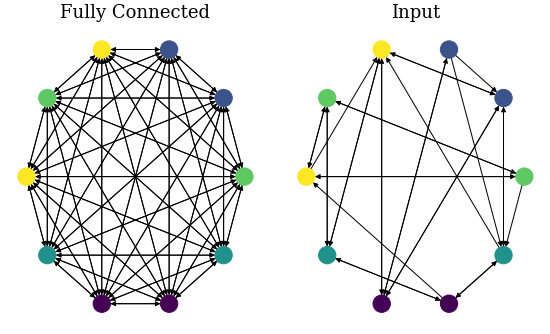

In [180]:
fig,axs = plt.subplots(ncols=2, figsize=(8,5))

plt.sca(axs[0])
nx.draw_circular(to_networkx( data, remove_self_loops=True), node_color=(data.node_id+1)//2)
axs[0].set_title('Fully Connected')

plt.sca(axs[1])
nx.draw_circular(to_networkx( mask_graph(data, data.edge_mask), remove_self_loops=True), node_color=(data.node_id+1)//2)
axs[1].set_title('Input')

fig.tight_layout()

In [190]:
model = gnn.modelMap['golden_knn'](dataset=template)

# model = gnn.modelMap['golden_knn'].load_from_checkpoint(
#     "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/pairing_methods/graph_net/models/golden_knn/lightning_logs/version_0/checkpoints/epoch=16-step=6136.ckpt"
#     ,dataset=template).to(device=gnn.config.device)

In [191]:
pre_node_o, pre_edge_o = model.predict(data)

In [192]:
from pytorch_lightning import Trainer 

trainer = Trainer(max_epochs=10, gpus=1*gnn.config.useGPU)
trainer.fit(model, trainloader, validloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params
-----------------------------------------------
0 | embed_1      | GCNLinear     | 768   
1 | conv_1       | GCNConvMSG    | 12.4 K
2 | relu_1       | GCNRelu       | 0     
3 | embed_2      | GCNLinear     | 16.6 K
4 | conv_2       | GCNConvMSG    | 49.3 K
5 | relu_2       | GCNRelu       | 0     
6 | node_readout | Sequential    | 15.6 K
7 | edge_readout | Sequential    | 15.6 K
8 | log_softmax  | GCNLogSoftmax | 0     
-----------------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.441     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 62/62 [00:07<00:00,  8.42it/s, loss=0.353, v_num=41]


In [186]:
trainer.test(model, testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 30/30 [00:03<00:00, 16.53it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'edge_acc/test': 0.6060231328010559,
 'edge_auroc/test': 0.8714444637298584,
 'kmax_acc/test': 0.5067175030708313,
 'loss/test': 0.35045719146728516,
 'node_acc/test': 0.727843165397644,
 'node_auroc/test': 0.6075496673583984}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 30/30 [00:03<00:00,  8.92it/s]


[{'loss/test': 0.35045719146728516,
  'node_acc/test': 0.727843165397644,
  'node_auroc/test': 0.6075496673583984,
  'edge_acc/test': 0.6060231328010559,
  'edge_auroc/test': 0.8714444637298584,
  'kmax_acc/test': 0.5067175030708313}]

In [187]:
post_node_o, post_edge_o = model.predict(data)

In [188]:
post_edge_mask = gnn.k_max_neighbors(post_edge_o, data.edge_index, 3)
goal_edge_mask = gnn.k_max_neighbors(data.edge_y, data.edge_index, 1)

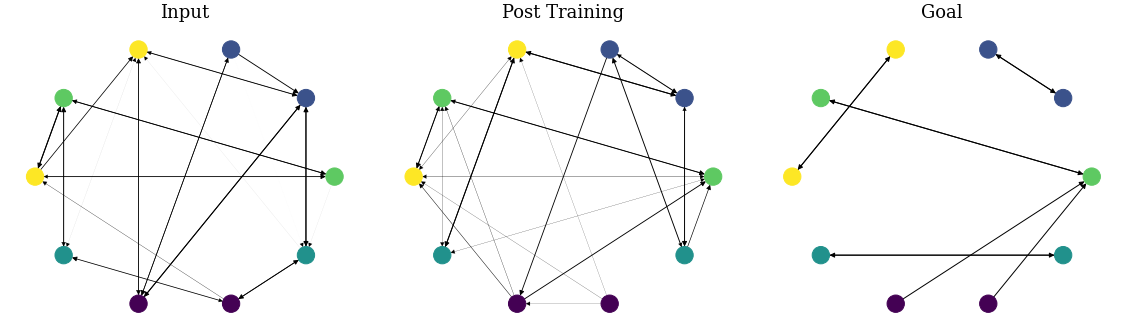

In [189]:
fig,axs = plt.subplots(ncols=3, figsize=(16,5))


plt.sca(axs[0])
nx.draw_circular(to_networkx( mask_graph(data, data.edge_mask), remove_self_loops=True), node_color=(data.node_id+1)//2, width=torch.exp(-data.edge_d))
axs[0].set_title('Input')

plt.sca(axs[1])
nx.draw_circular(to_networkx( mask_graph(data, post_edge_mask), remove_self_loops=True), node_color=(data.node_id+1)//2, width=post_edge_o)
axs[1].set_title('Post Training')

plt.sca(axs[2])
nx.draw_circular(to_networkx( mask_graph(data, goal_edge_mask), remove_self_loops=True), node_color=(data.node_id+1)//2)
axs[2].set_title('Goal')

fig.tight_layout()
